Labelbox（2020）フォーマットを使用！！

PascalVOC(xml)ファイル編集用

labelboxから出力されたjsonをPascalVOC形式に変換するモジュールpascal-voc-writerをインストール！！

In [1]:
!pip install pascal-voc-writer

# アノテーションファイルをダウンロード

アノテーションファイル（Downloads）をダウンロード

In [3]:
%cd C:\Users\spc134\Desktop\makecoco\PascalVOC

C:\Users\spc134\Desktop\makecoco\PascalVOC


In [1]:
#グーグルドライブからファイルをダウンロードする方法
#ファイル限定

import requests

def download_file_from_google_drive(id, destination):

    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)

    token = get_confirm_token(response)

    if token:

        params = { 'id' : id, 'confirm' : token }

        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):

    for key, value in response.cookies.items():

        if key.startswith('download_warning'):

            return value

    return None

def save_response_content(response, destination):

    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:

        for chunk in response.iter_content(CHUNK_SIZE):

            if chunk: # filter out keep-alive new chunks

                f.write(chunk)

#取得されるトークン
# file_id = '17j-pzxgiQNepFzE3_MsqRR2RsNQVhNKa' # Downloads_sumi.zip 108
file_id = '16ZPaf7XrPFFEIz1XTbZy6p63r5w3yz92' # Downloads_sumi.zip 918

#欲しいフォルダ名
destination = 'Downloads.zip'

download_file_from_google_drive(file_id, destination)

!unzip Downloads
print("Downloadsファイルの解凍が完了しました。")

Archive:  Downloads.zip
  inflating: Downloads/export-2020-09-21T02_40_17.775Z.json  
Downloadsファイルの解凍が完了しました。


# PascalVOC形式データセット作成

In [6]:
import json 
import os
import numpy as np
import cv2
from pascal_voc_writer import Writer

base_path = r'C:\Users\spc134\Desktop\makecoco'
# base_path = "/content"


if "PascalVOC" not in os.listdir(base_path):
    os.makedirs(os.path.join(base_path, "PascalVOC"))
else:
    print("PascalVOCは既に存在します")
SAVE_DIR = os.path.join(base_path, "PascalVOC") # PascalVOCのrootディレクトリ作成

PascalVOCは既に存在します


①Annotationsディレクトリを作成し、各画像のxmlファイルを作成。

②PNGImageディレクトリを作成し、jsonファイルからimgをダウンロード

In [7]:
import json 
import os
import numpy as np
import cv2
from pascal_voc_writer import Writer
import requests

base_path = r'C:\Users\spc134\Desktop\makecoco'
# base_path = "/content"

FILE_PATH = os.path.join(base_path, "Downloads") # jsonファイルのpath 

file_index = os.listdir(FILE_PATH) #アノテーションファイルをリストで取得
print('jsonファイルの数：', len(file_index))

# Annotationsディレクトリを作成
if "Annotations" not in os.listdir(os.path.join(base_path, "PascalVOC")):
    os.makedirs(os.path.join(base_path, "PascalVOC", "Annotations"))
else:
    print("Annotationsは既に存在します")
SAVE_ANNO_DIR = os.path.join(base_path, "PascalVOC", "Annotations") # 保存するimgファイルのpath

# # JPEGImagesディレクトリを作成
# if "PNGImages" not in os.listdir(os.path.join(base_path, "PascalVOC")):
#     os.makedirs(os.path.join(base_path, "PascalVOC", "PNGImages"))
# else:
#     print("PNGImagesは既に存在します")

# SAVE_IMG_DIR = os.path.join(base_path, "PascalVOC", "PNGImages") # 保存するファイルのpath

# JPEGImagesディレクトリを作成
if "Images" not in os.listdir(os.path.join(base_path, "PascalVOC")):
    os.makedirs(os.path.join(base_path, "PascalVOC", "Images"))
else:
    print("Imagesは既に存在します")

SAVE_IMG_DIR = os.path.join(base_path, "PascalVOC", "Images") # 保存するファイルのpath

count = 0
count_skip = 0
skip_list = []

# jsonファイル（クラスごとに分かれている）を順番に読み取り
for json_name in file_index:
    with open(os.path.join(FILE_PATH, json_name)) as json_f:
        json_open = json_f 
        json_load = json.load(json_open)
        # 各クラスの画像ファイルを読み取り(jsonを一行ごと読み取る、つまり画像を一枚ずつ読み取る)
        for json_row in json_load:
            # bboxがない画像はスキップする
            if not json_row['Label']:
                count_skip = count_skip + 1
                print('continue', count_skip, json_row['Label'])
                skip_list.append(json_row['External ID'])
                continue
            count = count + 1
            print('nomal', count)
            objects = json_row['Label']['objects']
            file_name = json_row['External ID']
            url = json_row['Labeled Data']
            response = requests.get(url)
            image = response.content
            # ②imgファイルを保存
            with open(os.path.join(SAVE_IMG_DIR, file_name), "wb") as f:
                f.write(image)
            print(file_name, os.path.join(SAVE_ANNO_DIR, file_name))
            # imgを読み込み
            src = cv2.imread(os.path.join(SAVE_IMG_DIR, file_name))
            print(src.shape)
            # Writer(path, width, height)
            writer = Writer(os.path.join(SAVE_ANNO_DIR, file_name), src.shape[1], src.shape[0])

            for num, obj in enumerate(objects):
                box = obj['bbox']
                top, left = (box['top'], box['left'])
                height, width = (box['height'], box['width'])
                name = obj['title']
                
                y_min, x_min = (int(top), int(left))
                y_max, x_max = (int(top)+int(height), int(left)+int(width))
                # ::addObject(name, xmin, ymin, xmax, ymax)
                writer.addObject(name, x_min, y_min, x_max, y_max)
            # ①Annotationファイルを保存
            # ::save(path)
            writer.save(os.path.join(SAVE_ANNO_DIR, file_name.replace('png', 'xml')))

print('nomal:', count)                    
print('continue:', count_skip)
print('skip_list:', skip_list)

jsonファイルの数： 1
nomal 1
200424_7_4_06.png C:\Users\spc134\Desktop\makecoco\PascalVOC\Annotations\200424_7_4_06.png
(747, 584, 3)
nomal 2
200424_7_2_08.png C:\Users\spc134\Desktop\makecoco\PascalVOC\Annotations\200424_7_2_08.png
(641, 521, 3)
nomal 3
200424_7_4_03.png C:\Users\spc134\Desktop\makecoco\PascalVOC\Annotations\200424_7_4_03.png
(747, 584, 3)
nomal 4
200424_7_2_05.png C:\Users\spc134\Desktop\makecoco\PascalVOC\Annotations\200424_7_2_05.png
(641, 520, 3)
nomal 5
200424_7_2_29.png C:\Users\spc134\Desktop\makecoco\PascalVOC\Annotations\200424_7_2_29.png
(641, 521, 3)
nomal 6
200424_7_2_02.png C:\Users\spc134\Desktop\makecoco\PascalVOC\Annotations\200424_7_2_02.png
(641, 520, 3)
nomal 7
200424_7_2_26.png C:\Users\spc134\Desktop\makecoco\PascalVOC\Annotations\200424_7_2_26.png
(641, 521, 3)
nomal 8
200424_7_4_28.png C:\Users\spc134\Desktop\makecoco\PascalVOC\Annotations\200424_7_4_28.png
(747, 584, 3)
nomal 9
200424_7_2_22.png C:\Users\spc134\Desktop\makecoco\PascalVOC\Annotations\2

In [9]:
# xmlファイルの数を確認
import json 
import os
import imageio
import numpy as np
import cv2
import matplotlib.pyplot as plt
from pascal_voc_writer import Writer

file_list = os.listdir(r'C:\Users\spc134\Desktop\makecocoPascalVOC/Annotations')
# file_list = os.listdir(os.path.join("/content/weeds", "hamasuge"))
print(len(file_list))

FileNotFoundError: ignored

In [5]:
# jpgファイルの数を確認
import json 
import os
import imageio
import numpy as np
import cv2
import matplotlib.pyplot as plt
from pascal_voc_writer import Writer

file_list = os.listdir(r'C:\Users\spc134\Desktop\makecocoPascalVOC/Images')
print(len(file_list))

894


③imageSetsディレクトリを作成

In [11]:
import os
import random

def make_train_files(base_path, val_num):
    
    train_file = open(os.path.join(base_path, "PascalVOC", "ImageSets", "Main", "train.txt"),'w')
    val_file = open(os.path.join(base_path, "PascalVOC", "ImageSets", "Main", "val.txt"),'w')
    text_t = ""
    text_v = ""
    num = 0
    # 
    for i in range(4):
        file_list = []
        for file in os.listdir(os.path.join(base_path, "PascalVOC", "Images")):
            if (i+1) == int(file.split('_')[2]):
                file_list.append(file)
        files = random.sample(file_list, int(val_num))
        print('index:', file_list[-1].split('_')[2], len(file_list))
        for file_name in file_list:
            if file_name in files:
                # print(file_name)
                file_name = file_name.replace('.png', '')
                # if text_v == "":text_v = file_name +'\n'
                text_v =text_v + file_name + '\n'
                num = num + 1
            else:
                # print(file_name)
                file_name = file_name.replace('.png', '')
                # if text_t == "":text_t = file_name
                text_t =text_t + file_name + '\n'                             
    train_file.write(text_t)
    val_file.write(text_v)
    print('val num:', num)


In [12]:
base_path = r'C:\Users\spc134\Desktop\makecoco'
# base_path = "/content"
imgpath = os.path.join(base_path, "weeds") # imageファイルのpath(入力)         
if "ImageSets" not in os.listdir(os.path.join(base_path, "PascalVOC")):
    os.makedirs(os.path.join(base_path, "PascalVOC", "ImageSets"))
if "Main" not in os.listdir(os.path.join(base_path, "PascalVOC", "ImageSets")):
    os.makedirs(os.path.join(base_path, "PascalVOC", "ImageSets", "Main"))

main_dir = os.path.join(base_path, "PascalVOC", "ImageSets", "Main")
os.chdir(main_dir)
pwd = os.getcwd()
print(pwd)
val_num = 9

make_train_files(base_path, val_num)


C:\Users\spc134\Desktop\makecoco\PascalVOC\ImageSets\Main
index: 1 315
index: 2 132
index: 3 315
index: 4 132
val num: 36


確認！！！画像にボックスのプロットを表示

ストリーミング出力は最後の 5000 行に切り捨てられました。
344 390 360 404
343 415 351 422
[185, 160]
[[[185, 160], [196, 169]], [[180, 108], [185, 113]], [[200, 192], [209, 202]], [[304, 344], [314, 353]], [[283, 354], [297, 368]], [[344, 390], [360, 404]], [[343, 415], [351, 422]]]
<class 'numpy.ndarray'>
200504_7_1_30.xml
C:\Users\spc134\Desktop\makecoco\PascalVOC\Images/200504_7_1_30.png
456
603
xmin type 326
326 476 338 490
335 465 346 476
334 441 344 449
306 408 320 419
284 398 294 407
261 387 270 397
331 387 340 392
300 376 305 381
263 360 269 369
354 331 364 343
259 320 268 330
237 325 243 330
236 309 249 322
213 307 221 315
212 255 219 260
158 199 170 211
174 193 179 199
188 184 196 193
153 175 162 185
123 135 132 143
146 127 154 136
141 102 156 118
[326, 476]
[[[326, 476], [338, 490]], [[335, 465], [346, 476]], [[334, 441], [344, 449]], [[306, 408], [320, 419]], [[284, 398], [294, 407]], [[261, 387], [270, 397]], [[331, 387], [340, 392]], [[300, 376], [305, 381]], [[263, 360], [269, 369]], [[354, 331],

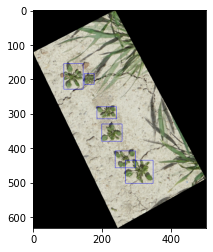

In [13]:
from bs4 import BeautifulSoup
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

base_path = r'C:\Users\spc134\Desktop\makecoco'
# base_path = "/content"

filedir = os.path.join(base_path, "PascalVOC", "Annotations")
filedir_fig = os.path.join(base_path, "PascalVOC", "Images")

filelist = os.listdir(path=filedir) # xmlファイル名をリストで取得

for filename in filelist:
  print(filename)
  name = filename.split('.')
  # '.ipynb_checkpoints'の場合スキップ
  if filename == '.ipynb_checkpoints':
    continue
  fp_xml = filedir + '/' + name[0] +'.xml'
  fp_fig = filedir_fig + '/' + name[0] + '.png'
  print(fp_fig)
  # ファイルの読み込み
  f_r = open(fp_xml)
  soup = BeautifulSoup(f_r, 'xml')
  f_r.close()
  print(soup.annotation.size.width.string)
  print(soup.annotation.size.height.string)
  # xmin = int(float(soup.annotation.bndbox.xmin.string))
  # ymin = int(float(soup.annotation.bndbox.ymin.string))
  # xmax = int(float(soup.annotation.bndbox.xmax.string))
  # ymax = int(float(soup.annotation.bndbox.ymax.string))
  print('xmin type', soup.annotation.object.bndbox.xmin.string)
  src_pts = []
  for obj in soup.find_all('object'):
     xmin = int(float(obj.find('xmin').string))
     ymin = int(float(obj.find('ymin').string))
     xmax = int(float(obj.find('xmax').string))
     ymax = int(float(obj.find('ymax').string))
     print(xmin,ymin,xmax,ymax)
     src_pts.append([[xmin, ymin], [xmax, ymax]])
  src = cv2.imread(fp_fig)
  src_mark = src.copy()
  print(src_pts[0][0])
  print(src_pts)
  for pt in src_pts:
    cv2.rectangle(src_mark, tuple(pt[0]), tuple(pt[1]), (255, 0, 0), thickness=1)
  print(type(src))
  # cv2.imwrite(savedir, src)
  plt.imshow(cv2.cvtColor(src_mark, cv2.COLOR_BGR2RGB))
  # break




In [11]:
# %cd /content
%cd C:\Users\spc134\Desktop\makecoco

/content


PascalVOCを圧縮

In [10]:
!zip -r PascalVOC PascalVOC

  adding: PascalVOC/ (stored 0%)
  adding: PascalVOC/PNGImages/ (stored 0%)
  adding: PascalVOC/PNGImages/200427_7_2_06.png (deflated 0%)
  adding: PascalVOC/PNGImages/200428_7_3_09.png (deflated 0%)
  adding: PascalVOC/PNGImages/200423_7_3_21.png (deflated 0%)
  adding: PascalVOC/PNGImages/200428_7_4_14.png (deflated 1%)
  adding: PascalVOC/PNGImages/200514_7_3_06.png (deflated 0%)
  adding: PascalVOC/PNGImages/200430_7_1_02.png (deflated 0%)
  adding: PascalVOC/PNGImages/200424_7_4_24.png (deflated 0%)
  adding: PascalVOC/PNGImages/200507_7_3_17.png (deflated 0%)
  adding: PascalVOC/PNGImages/200427_7_2_23.png (deflated 1%)
  adding: PascalVOC/PNGImages/200511_7_1_08.png (deflated 0%)
  adding: PascalVOC/PNGImages/200424_7_3_16.png (deflated 0%)
  adding: PascalVOC/PNGImages/200424_7_3_15.png (deflated 0%)
  adding: PascalVOC/PNGImages/200424_7_1_28.png (deflated 0%)
  adding: PascalVOC/PNGImages/200424_7_2_09.png (deflated 0%)
  adding: PascalVOC/PNGImages/200430_7_1_27.png (deflate